# Home Credit Default Risk

Source : https://www.kaggle.com/c/home-credit-default-risk/overview 

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Data Description

---application_{train|test}.csv---

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

---bureau.csv---

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

---bureau_balance.csv---

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

---POS_CASH_balance.csv---

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

---credit_card_balance.csv---

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


---previous_application.csv---

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.


---installments_payments.csv---

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


---HomeCredit_columns_description.csv---

This file contains descriptions for the columns in the various data files.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# import preprocessing from sklearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder

# 1.0 Data Loading

In [15]:
#loading the files

root_path = 'C:/Users/Jitendra Chauhan/Documents/Jitu/UFT/Machine Learning/Final Project/Home_Credit_Default_Risk/data/home-credit-default-risk/'
df_train = pd.read_csv(root_path +'application_train.csv')
df_test = pd.read_csv(root_path +'application_test.csv')

df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("Shape of the Training set: ", df_train.shape)
print("Shape of the Testing set: ", df_test.shape)
df_train.describe()

Shape of the Training set:  (307511, 122)
Shape of the Testing set:  (48744, 121)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [17]:
#to check if any of the column is having null value or missing value
df_train.isnull().sum().sort_values(ascending=False)

COMMONAREA_MEDI                214865
COMMONAREA_AVG                 214865
COMMONAREA_MODE                214865
NONLIVINGAPARTMENTS_MODE       213514
NONLIVINGAPARTMENTS_MEDI       213514
                                ...  
REG_CITY_NOT_LIVE_CITY              0
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 122, dtype: int64

# 2.0 Data Exploration

# 2.1 Total Loan - Paid/ Unpaid

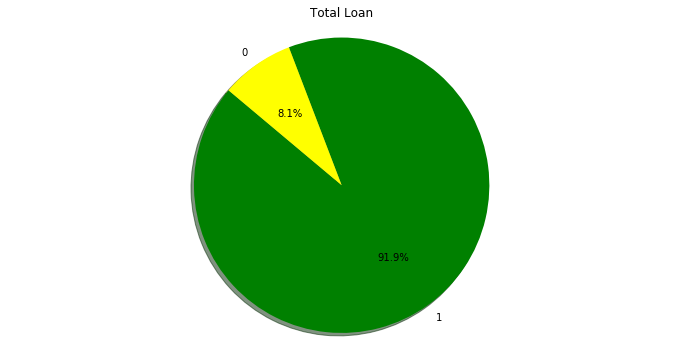

In [18]:
#check the count of target  variable
x =df_train['TARGET'].value_counts()
y= df_train['TARGET'].unique()

plt.figure(figsize=(12,6))
plt.title('Total Loan')
colors = ['green', 'yellow']
# Plot
plt.pie(x, labels=y, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Here,

0 - Loan paid on time, 
1 - Loan not paid

There are more than 90% time the loan is paid compared to not paid.

It can be conclude that data is highly imbalanced.


In [19]:
# count the numbers of field as per data type
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [20]:
df_train.select_dtypes('object').head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [21]:

#to find the null values as per Category colums equal to object

cat_columns = df_train.select_dtypes('object').columns
print(cat_columns)
df_train[cat_columns].isnull().sum().sort_values(ascending=False) 

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


FONDKAPREMONT_MODE            210295
WALLSMATERIAL_MODE            156341
HOUSETYPE_MODE                154297
EMERGENCYSTATE_MODE           145755
OCCUPATION_TYPE                96391
NAME_TYPE_SUITE                 1292
ORGANIZATION_TYPE                  0
WEEKDAY_APPR_PROCESS_START         0
NAME_HOUSING_TYPE                  0
NAME_FAMILY_STATUS                 0
NAME_EDUCATION_TYPE                0
NAME_INCOME_TYPE                   0
FLAG_OWN_REALTY                    0
FLAG_OWN_CAR                       0
CODE_GENDER                        0
NAME_CONTRACT_TYPE                 0
dtype: int64

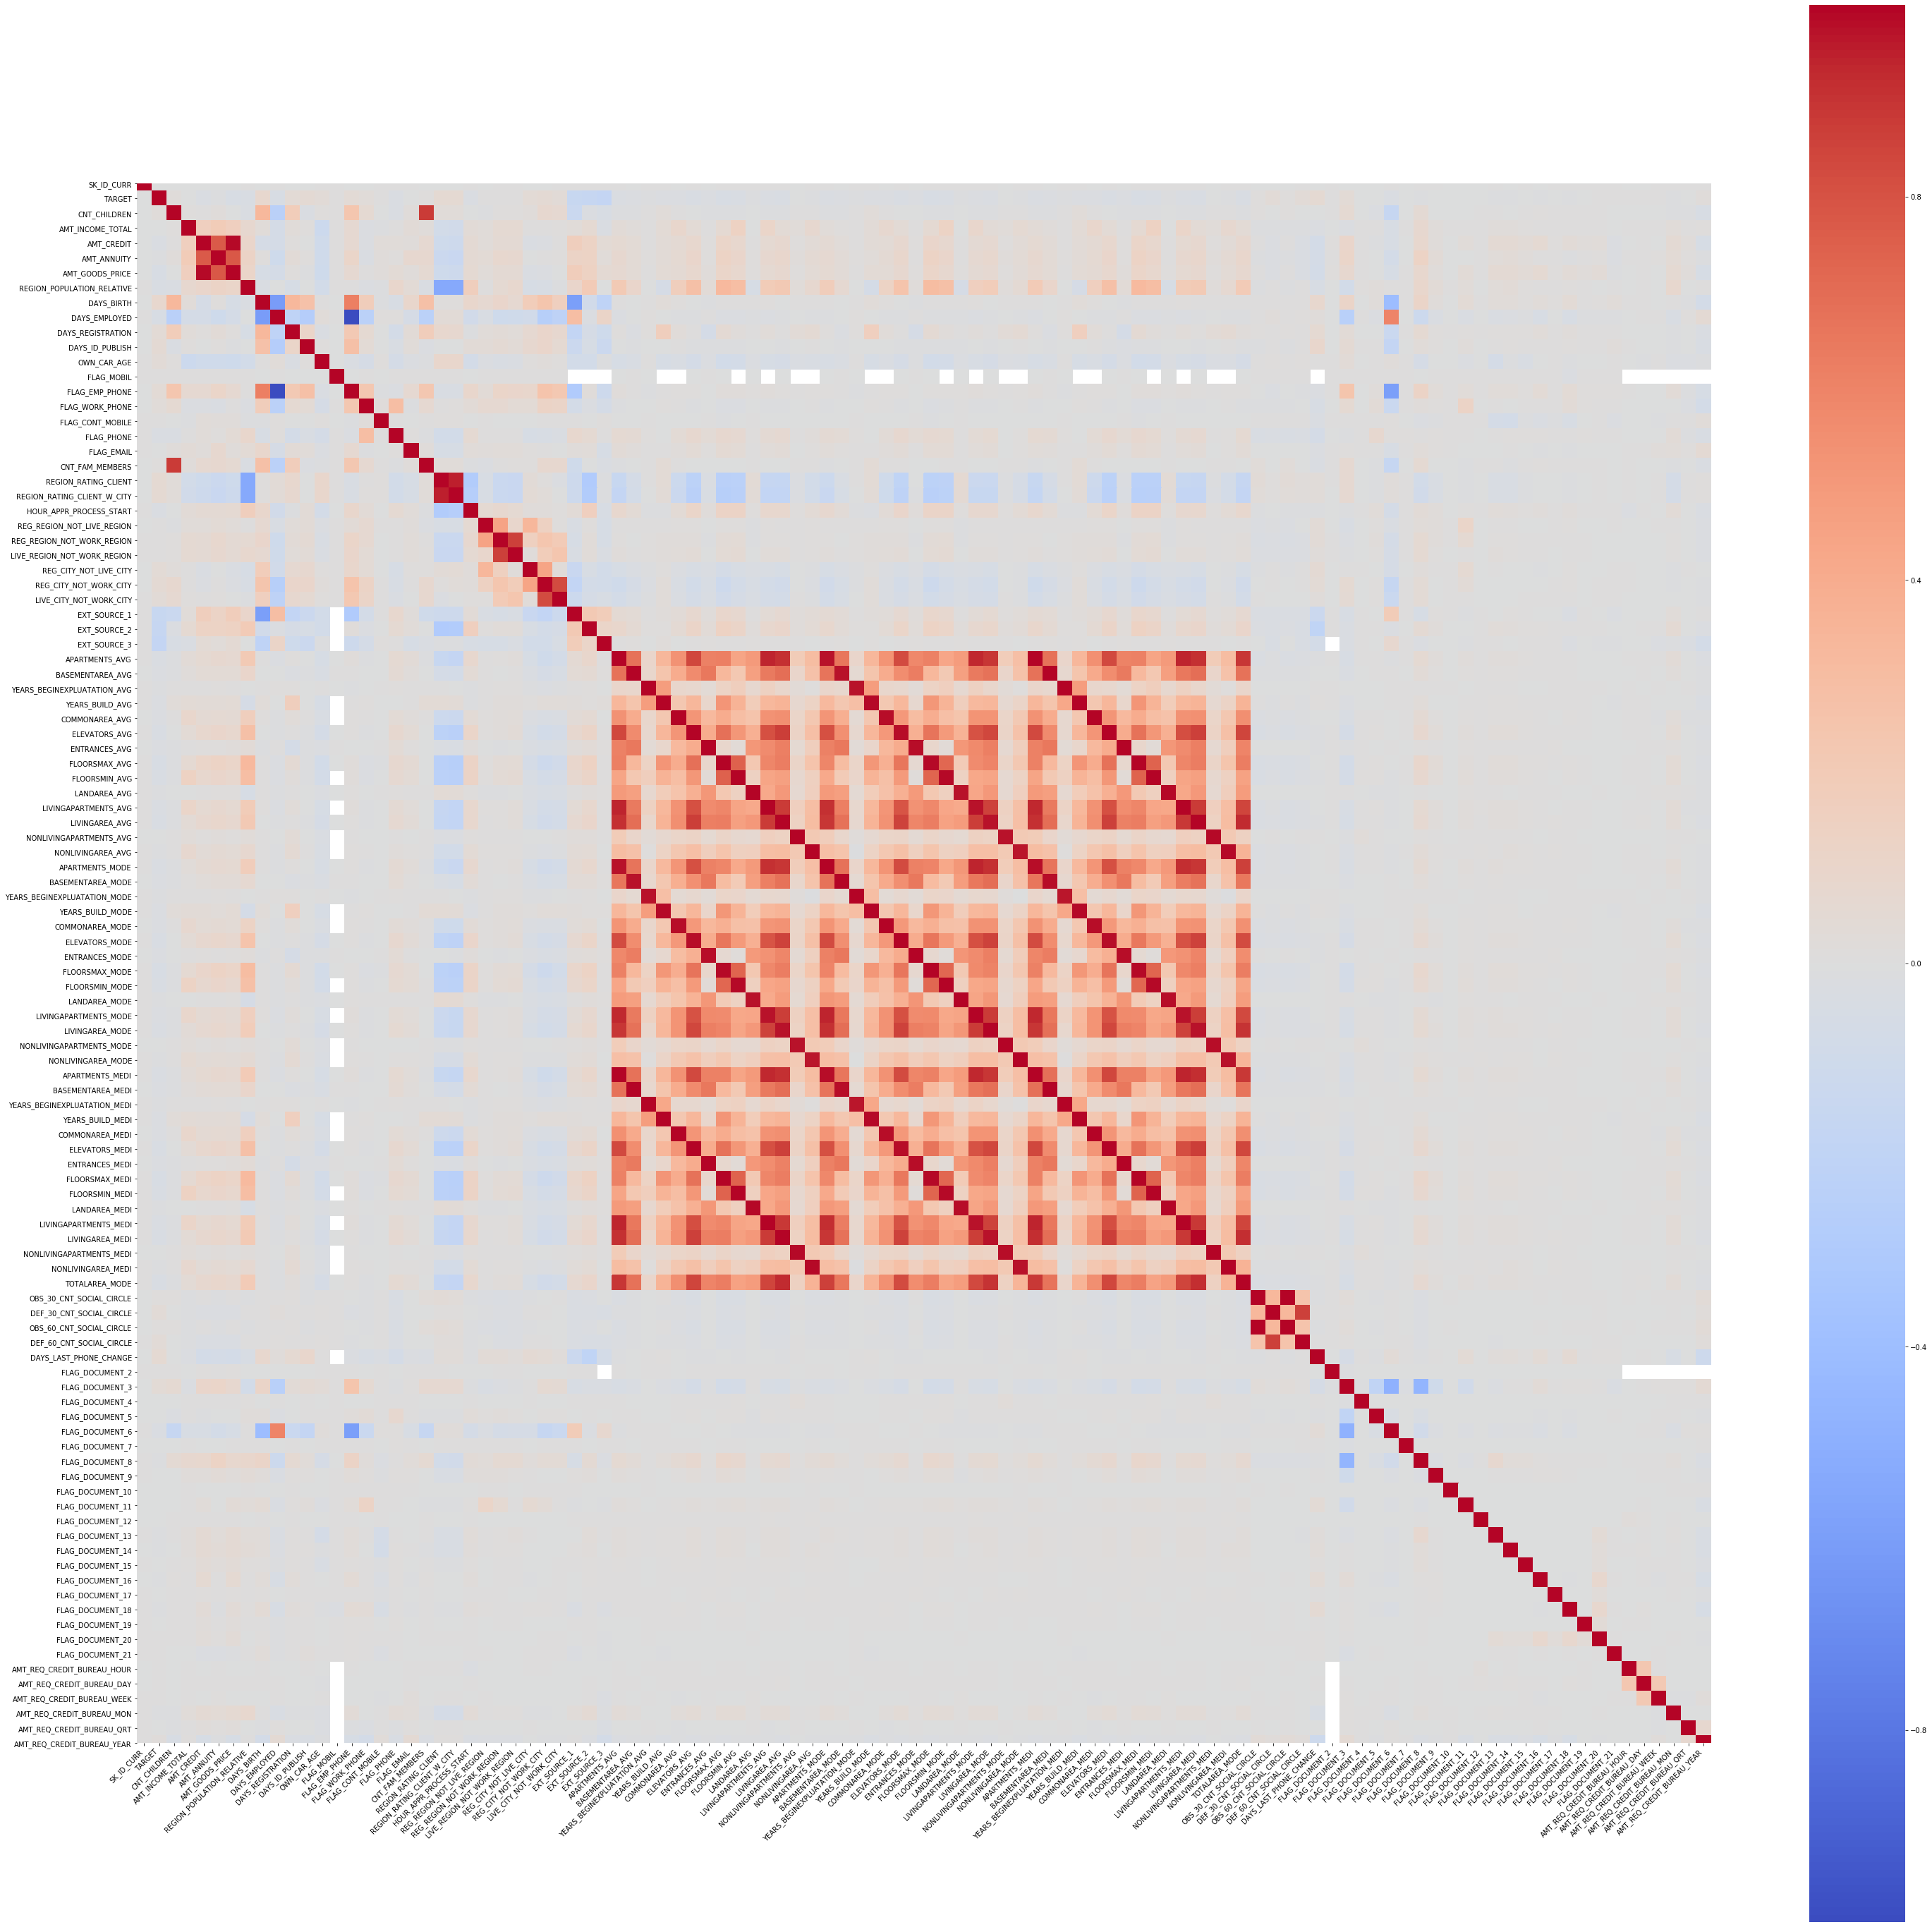

In [22]:
plt.figure(figsize = (50, 50))

corr = df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True)
#sns.diverging_palette(20, 220, n=200)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

In [23]:
# Create correlation matrix
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
print("Features highly correlated")
feat_high_corr = list([column for column in upper.columns if any(upper[column] > 0.95)])
print(feat_high_corr)

# Drop features 
#df_train.drop(to_drop, axis=1, inplace=True)

#print(df_train.shape)
#df_train.head()

Features highly correlated
['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE']


CONCLUSION : From the heatmap, it can be concluded that most of the features are not correlated with the Target feature.

Also, the features regarding the client's building informations are highly correlated with each other. So we can ignore these features during our feature engineering.

This maps shows the positive and negative correlation of other features with the Target Feature



# 2.2 Histogram

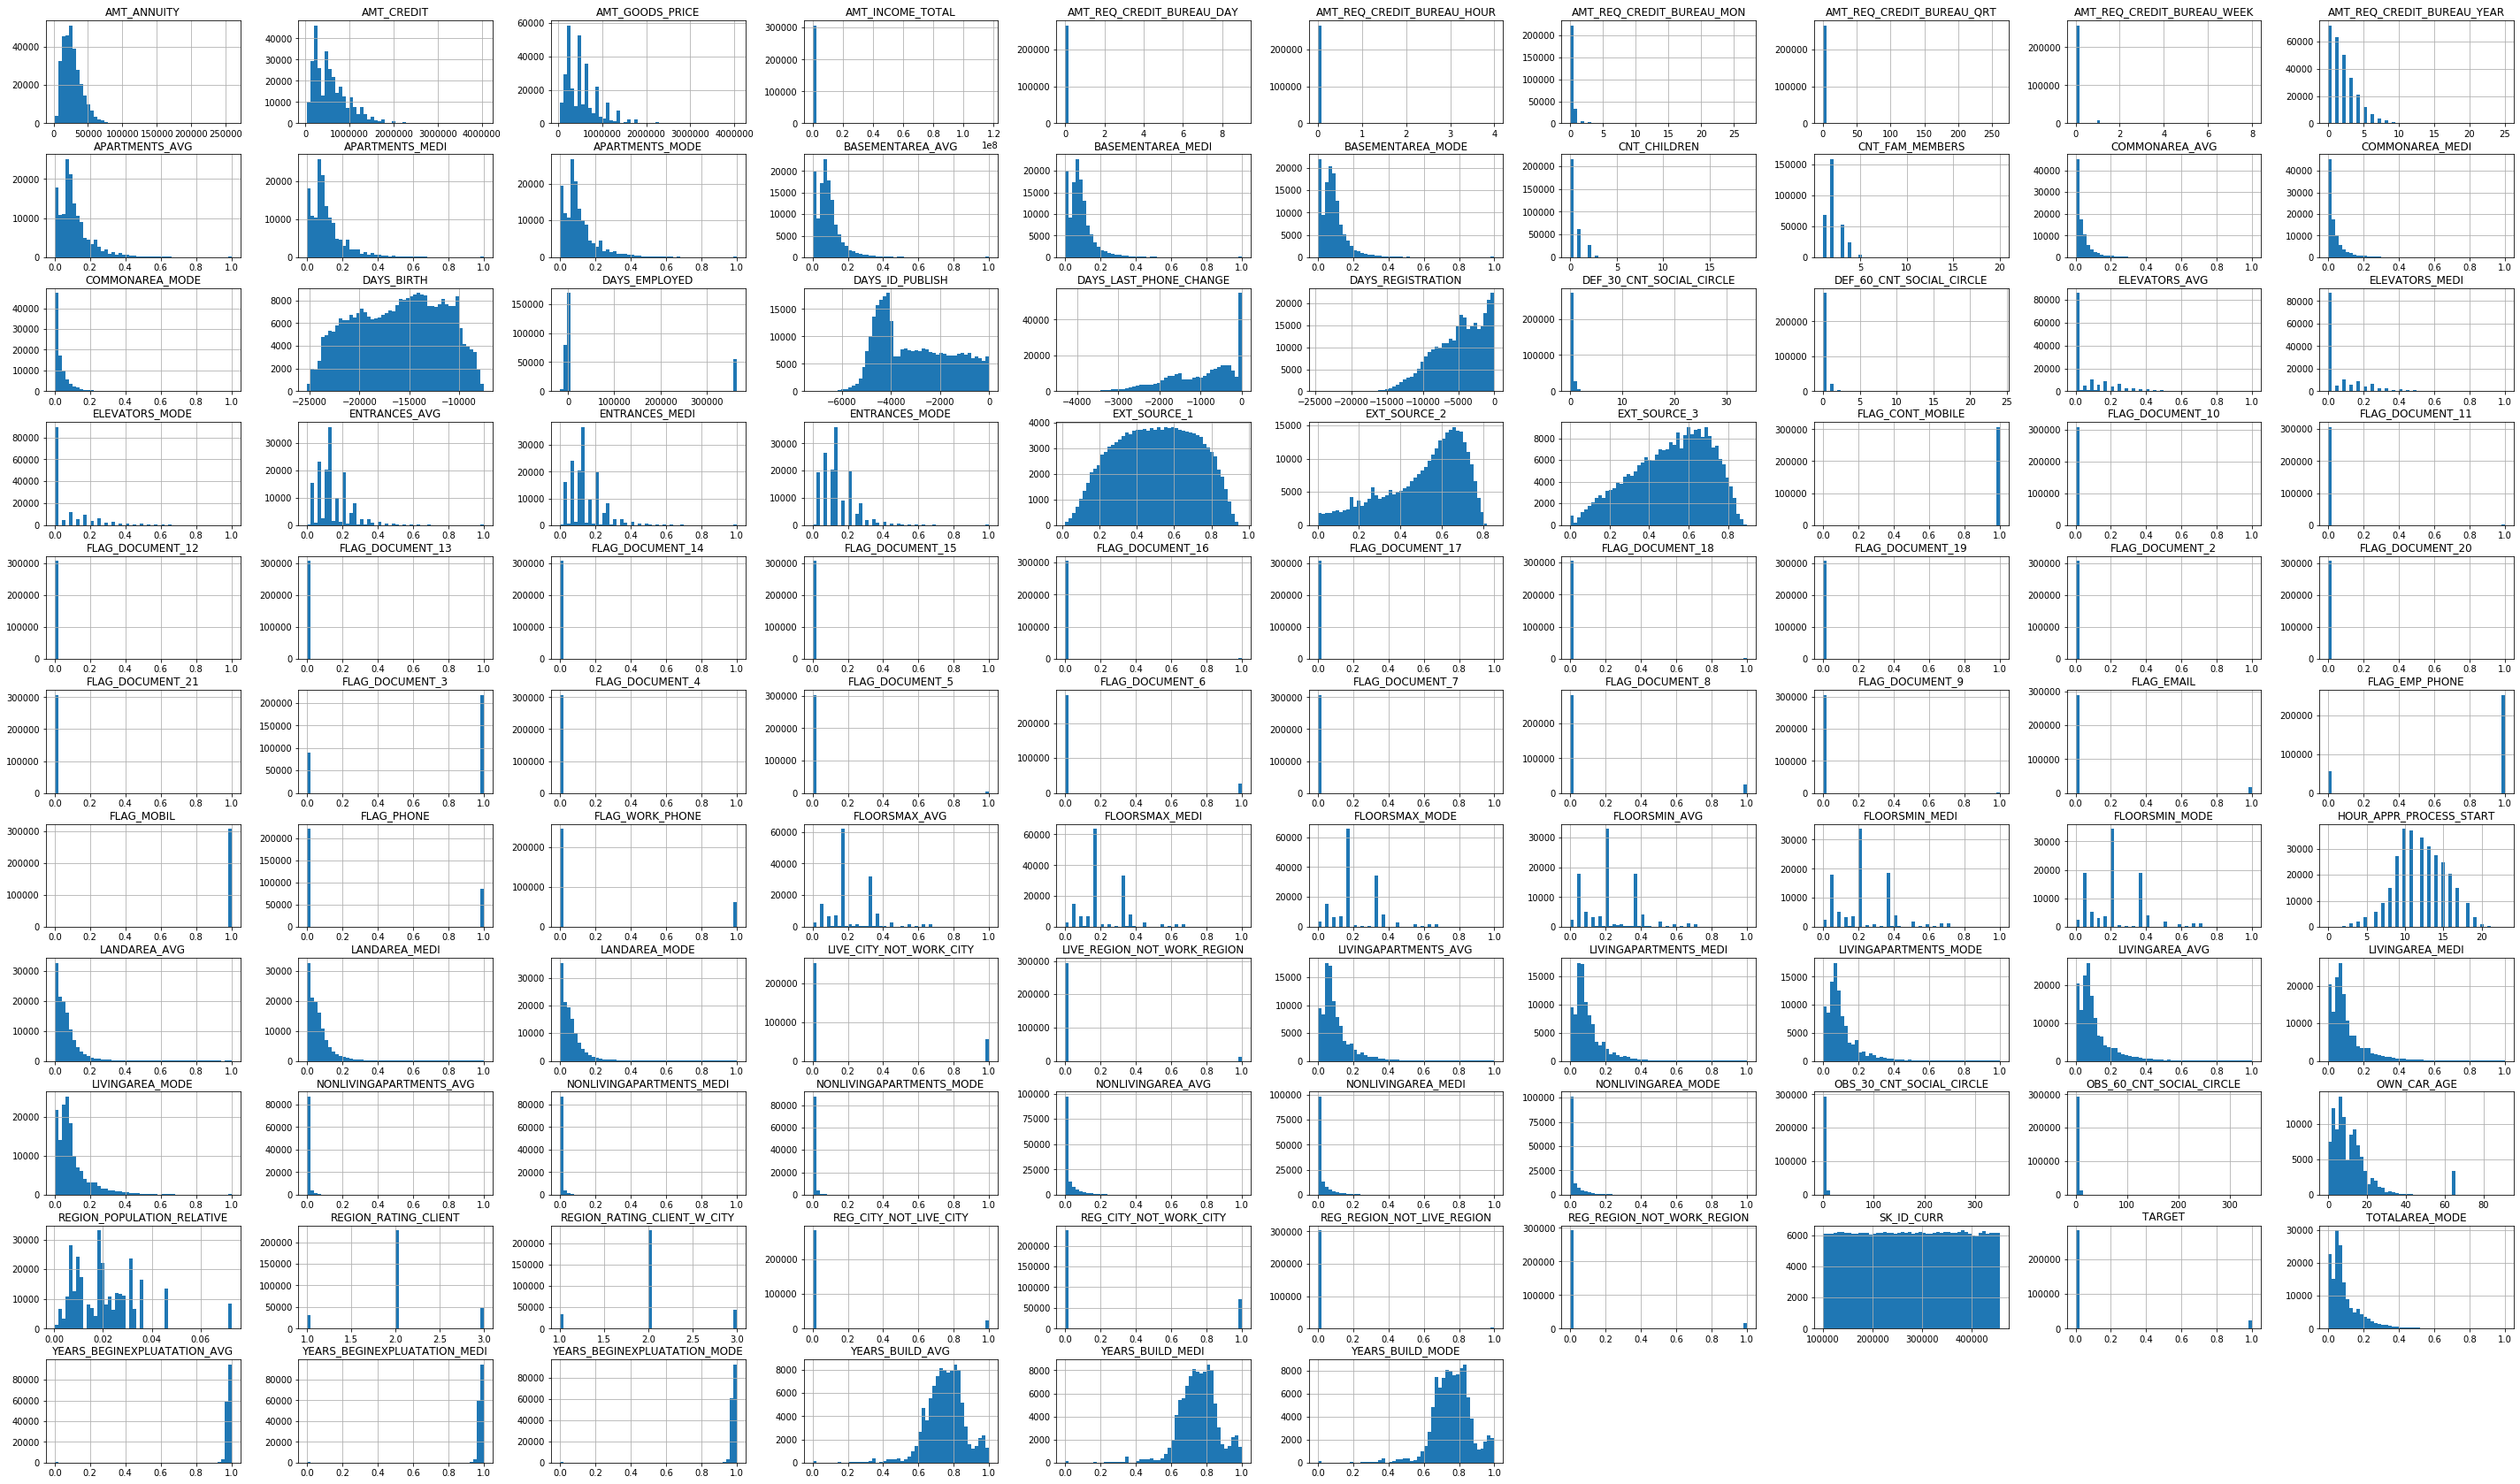

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train.hist(bins=50, figsize=(50,30))
#save_fig("attribute_histogram_plots")
plt.show()

# 2.4 Type of Loan Percentage

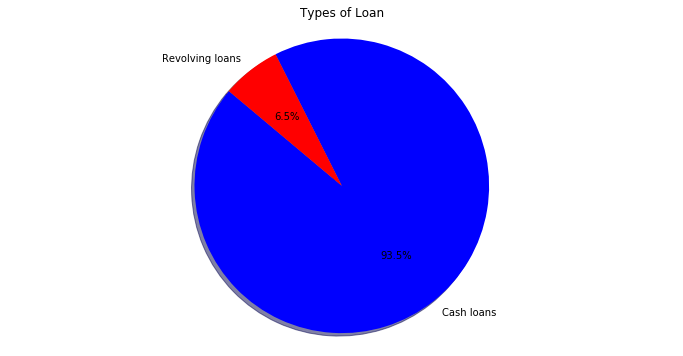

In [25]:
x =df_train.groupby('NAME_CONTRACT_TYPE')['TARGET'].sum()
y= df_train['NAME_CONTRACT_TYPE'].unique()

plt.figure(figsize=(12,6))
plt.title('Types of Loan')
colors = ['blue', 'red']
# Plot
plt.pie(x, labels=y, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# 2.5 Loan as per Client's Occupation

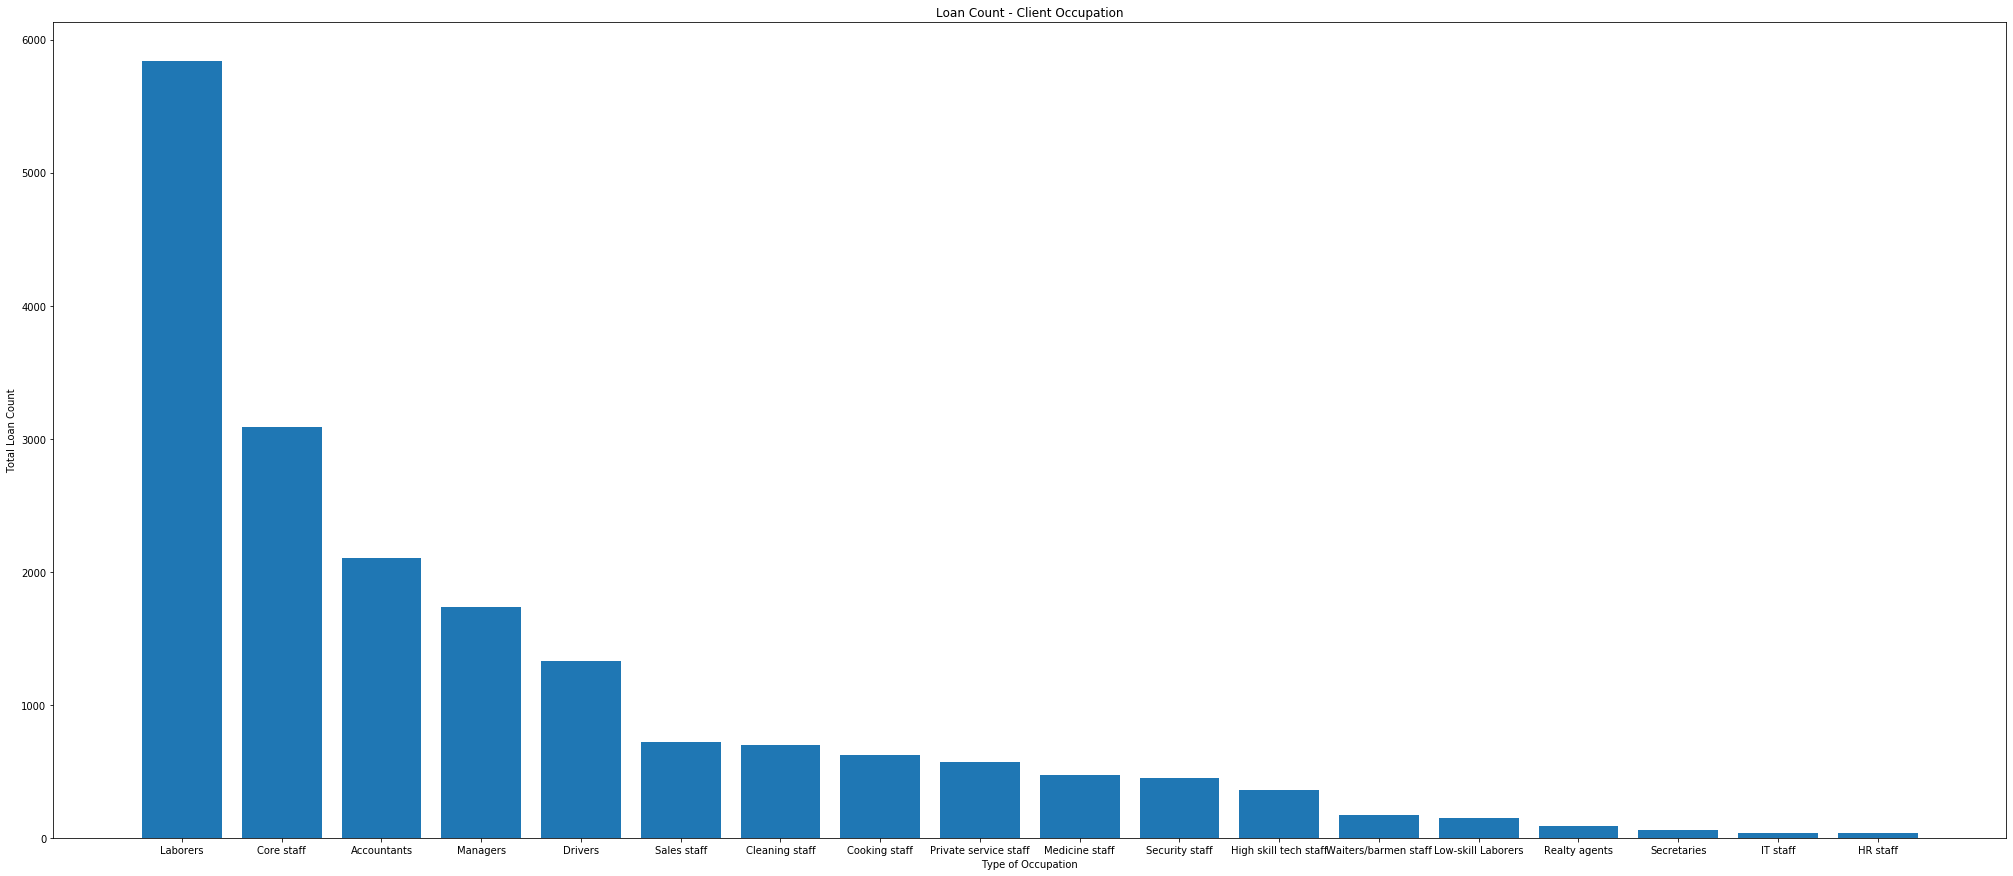

In [27]:
#OCCUPATION_TYPE

x =df_train.groupby('OCCUPATION_TYPE')['TARGET'].sum().sort_values(ascending=False)
y= df_train['OCCUPATION_TYPE'].unique()

y = [i for i in y if str(i) != 'nan']
#print (x)
#print(y)

plt.figure(figsize=(35,15))
plt.title('Loan Count - Client Occupation')
plt.xlabel('Type of Occupation')
plt.ylabel('Total Loan Count')

plt.bar(y, x,align='center', alpha=1)
    
#plt.axis('equal')
plt.show()


# 2.6 Loan Count - as per Number of Family Members

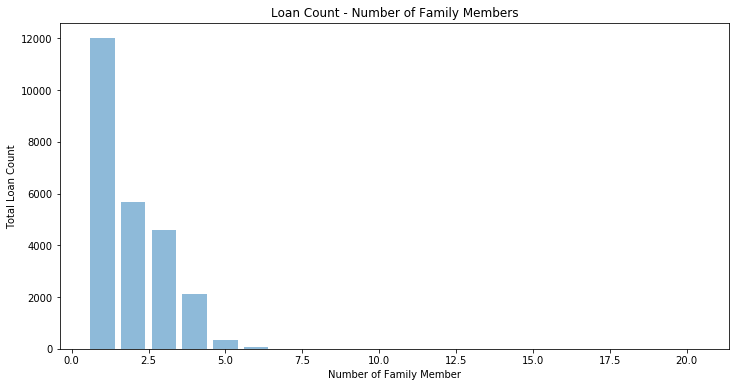

In [33]:
#CNT_FAM_MEMBERS
x =df_train.groupby('CNT_FAM_MEMBERS')['TARGET'].sum().sort_values(ascending=False)
y= df_train['CNT_FAM_MEMBERS'].unique()
y = [i for i in y if str(i) != 'nan']



plt.figure(figsize=(12,6))
plt.title('Loan Count - Number of Family Members')
plt.xlabel('Number of Family Member')
plt.ylabel('Total Loan Count')


plt.bar(y, x,align='center', alpha=0.5)
    
#plt.axis('equal')
plt.show()

# 2.7 Loan as per Client's Housing Type

NAME_HOUSING_TYPE
House / apartment      21272
With parents            1736
Municipal apartment      955
Rented apartment         601
Office apartment         172
Co-op apartment           89
Name: TARGET, dtype: int64
['House / apartment', 'Rented apartment', 'With parents', 'Municipal apartment', 'Office apartment', 'Co-op apartment']


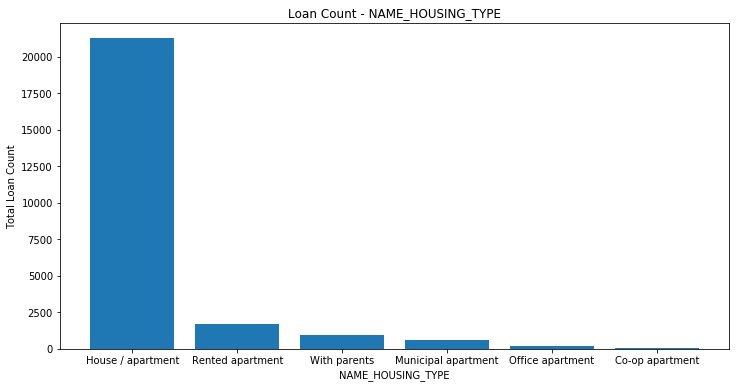

In [60]:
#NAME_HOUSING_TYPE

x =df_train.groupby('NAME_HOUSING_TYPE')['TARGET'].sum().sort_values(ascending=False)
y= df_train['NAME_HOUSING_TYPE'].unique()

y = [i for i in y if str(i) != 'nan']

print(x)
print(y)

plt.figure(figsize=(12,6))
plt.title('Loan Count - NAME_HOUSING_TYPE')
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Total Loan Count')


plt.bar(y, x,align='center', alpha=1)
    
#plt.axis('equal')
plt.show()


# 2.8 Loan as per Client's Age

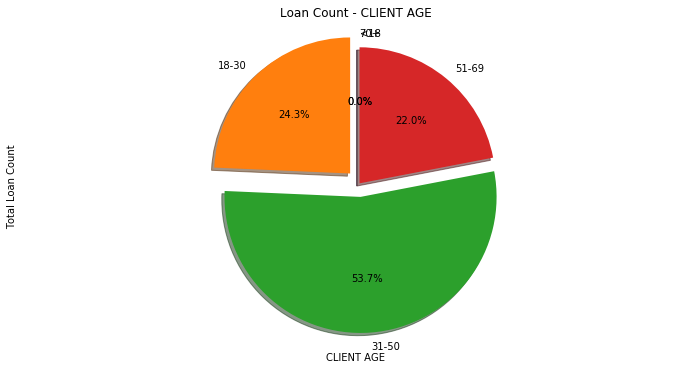

In [65]:

#DAYS_BIRTH


df_train['AGE_IN_YEARS'] = abs(df_train['DAYS_BIRTH'])/365.25

bins = [1,18, 31, 51, 70,125]
labels = ['<18','18-30', '31-50',  '51-69', '70+']
df_train['AGE_IN_YEARS_BUCKET'] = pd.cut(df_train['AGE_IN_YEARS'], bins, labels = labels,include_lowest = True)

x =df_train.groupby('AGE_IN_YEARS_BUCKET')['TARGET'].sum()
y= labels #df_train['AGE_IN_YEARS_BUCKET']
y = [i for i in y if str(i) != 'nan']


plt.figure(figsize=(12,6))
plt.title('Loan Count - CLIENT AGE')
plt.xlabel('CLIENT AGE')
plt.ylabel('Total Loan Count')


plt.pie(x, labels=y, autopct='%1.1f%%', explode=(0, 0.1,0.1, 0, 0),shadow=True, startangle=90)

    
plt.axis('equal')
plt.show()
#df_train['AGE_IN_YEARS_BUCKET'] .head()